In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

In [2]:
import InbeddingDiagramDNeg as Dia
import WormholeRayTracer as wrmhole
import WormholeGraphics as wg
import Symplectic_DNeg as Smpl

In [3]:
path = os.getcwd()

In [4]:
Par = [0.8/1.42953, 8.6*2/3, 4.3*2/3] # M, rho, a parameters wormhole

initial_q = np.array([12, np.pi, np.pi/2])

In [5]:
print(Par, initial_q)
Grid_dimension = '3D'
mode = 0
Motion1, Grid1, CM1 = wrmhole.Simulate_DNeg(Smpl.Sympl_DNeg, Par, 0.05, 2000, initial_q, 20**2, 20**2, Grid_dimension, mode, wg.Grid_constr_3D_Sph)

[12.          3.14159265  1.57079633]
176.6373109817505


In [6]:
Cosyst =  ' Sph '
cv2.imwrite(os.path.join(path, "Pictures/Image "+Grid_dimension+"Gr"+Cosyst+"DNeg Sympl"+str(Par)+" "+str(initial_q)+".png"),
            255*wg.Make_Pict_RGBP(Motion1[-1, 1], Grid1))

True

In [7]:
cv2.imwrite(os.path.join(path, "Pictures/Image "+"2DGr DNeg Sympl"+str(Par)+" "+str(initial_q)+".png"),
            255*wg.Make_Pict_RGBP(Motion1[-1, 1], wg.Grid_constr_2D(Motion1[-1, 1], 11, 1, 0.05)))

True

In [8]:
cv2.imwrite(os.path.join(path, "Pictures/Image "+"NoGrid DNeg Sympl"+str(Par)+" "+str(initial_q)+".png"),
            255*wg.Make_Pict_RGBP(Motion1[-1, 1], np.zeros(Motion1[-1, 1, 0].shape, dtype=bool)))

True

In [9]:
Motion2 = wrmhole.simulate_raytracer_fullpath(100, Par, initial_q, 20**2, 20**2)

Initializing screen and calculating initial condition...
Iteration (0, 399) completed in 0.007863044738769531s.
Iteration (1, 399) completed in 0.007874727249145508s.
Iteration (2, 399) completed in 0.007864952087402344s.
Iteration (3, 399) completed in 0.0073931217193603516s.
Iteration (4, 399) completed in 0.007486820220947266s.
Iteration (5, 399) completed in 0.007309675216674805s.
Iteration (6, 399) completed in 0.006971120834350586s.
Iteration (7, 399) completed in 0.007209062576293945s.
Iteration (8, 399) completed in 0.007441997528076172s.
Iteration (9, 399) completed in 0.007215738296508789s.
Iteration (10, 399) completed in 0.00722503662109375s.
Iteration (11, 399) completed in 0.007448911666870117s.
Iteration (12, 399) completed in 0.006894111633300781s.
Iteration (13, 399) completed in 0.0068798065185546875s.
Iteration (14, 399) completed in 0.007026195526123047s.
Iteration (15, 399) completed in 0.006914854049682617s.
Iteration (16, 399) completed in 0.0069849491119384766s.

Iteration (145, 399) completed in 0.008160591125488281s.
Iteration (146, 399) completed in 0.008268117904663086s.
Iteration (147, 399) completed in 0.008162975311279297s.
Iteration (148, 399) completed in 0.009289026260375977s.
Iteration (149, 399) completed in 0.006592988967895508s.
Iteration (150, 399) completed in 0.0069119930267333984s.
Iteration (151, 399) completed in 0.006738901138305664s.
Iteration (152, 399) completed in 0.0068132877349853516s.
Iteration (153, 399) completed in 0.006849050521850586s.
Iteration (154, 399) completed in 0.007264137268066406s.
Iteration (155, 399) completed in 0.0067980289459228516s.
Iteration (156, 399) completed in 0.007318019866943359s.
Iteration (157, 399) completed in 0.009775161743164062s.
Iteration (158, 399) completed in 0.0065441131591796875s.
Iteration (159, 399) completed in 0.008028984069824219s.
Iteration (160, 399) completed in 0.007460832595825195s.
Iteration (161, 399) completed in 0.007663726806640625s.
Iteration (162, 399) comple

Iteration (289, 399) completed in 0.008069038391113281s.
Iteration (290, 399) completed in 0.008018970489501953s.
Iteration (291, 399) completed in 0.008907079696655273s.
Iteration (292, 399) completed in 0.008481979370117188s.
Iteration (293, 399) completed in 0.00841379165649414s.
Iteration (294, 399) completed in 0.008002042770385742s.
Iteration (295, 399) completed in 0.008684635162353516s.
Iteration (296, 399) completed in 0.008533000946044922s.
Iteration (297, 399) completed in 0.007108211517333984s.
Iteration (298, 399) completed in 0.007300138473510742s.
Iteration (299, 399) completed in 0.00757288932800293s.
Iteration (300, 399) completed in 0.00861811637878418s.
Iteration (301, 399) completed in 0.008856058120727539s.
Iteration (302, 399) completed in 0.008101940155029297s.
Iteration (303, 399) completed in 0.00890803337097168s.
Iteration (304, 399) completed in 0.008790969848632812s.
Iteration (305, 399) completed in 0.007905960083007812s.
Iteration (306, 399) completed in 0

In [10]:
cv2.imwrite(os.path.join(path, "Pictures/Image "+"2DGr DNeg Scipy intgr."+str(Par)+" "+str(initial_q)+".png"),
            255*wg.Make_Pict_RGBP(Motion2[-1, 1], wg.Grid_constr_2D(Motion2[-1, 1], 11, 1, 0.05)))

True

<IPython.core.display.Javascript object>


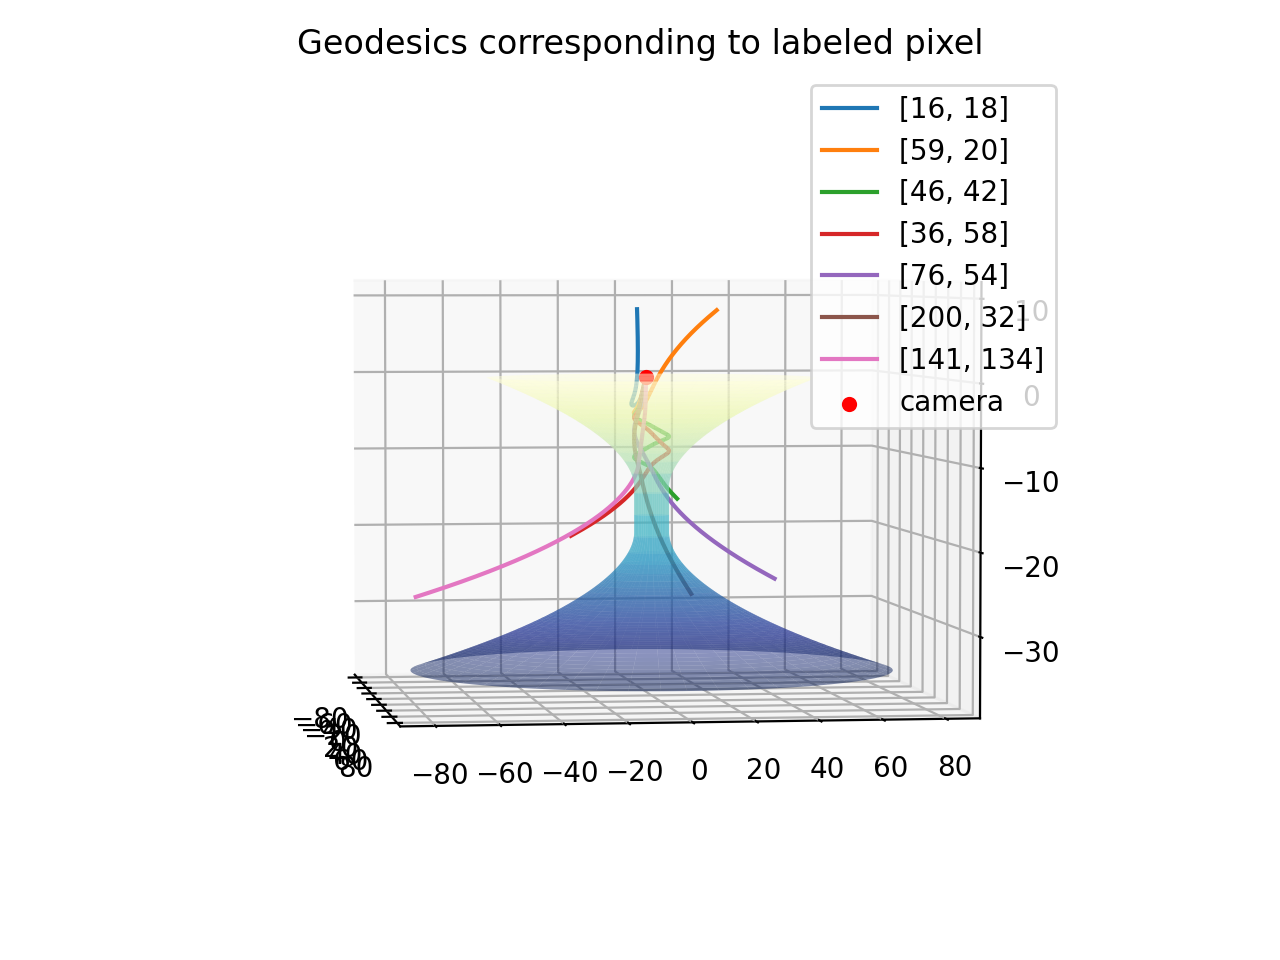

In [12]:
Geo_label = None #list of strings for labeling geodesics, turn Geo_sel to None
#Geo_Sel = None
Geo_Sel = [[16,18],[59,20],[46,42],[36,58],[76,54],[200,32],[141,134]]
if Geo_Sel == None:
    Geo_txt = ""
else:
    Geo_txt = str(Geo_Sel)
wg.gdsc(Motion1, Par, "Pictures/geodesics "+Geo_txt+" DNeg Sympl"+str(Par)+" "+str(initial_q)+".png", path, Geo_label, Geo_Sel)

In [13]:
CM2 = np.array([wrmhole.DNeg_CM(Motion2[k,0], Motion2[k,1], Par) for k in range(len(Motion2))])

<IPython.core.display.Javascript object>


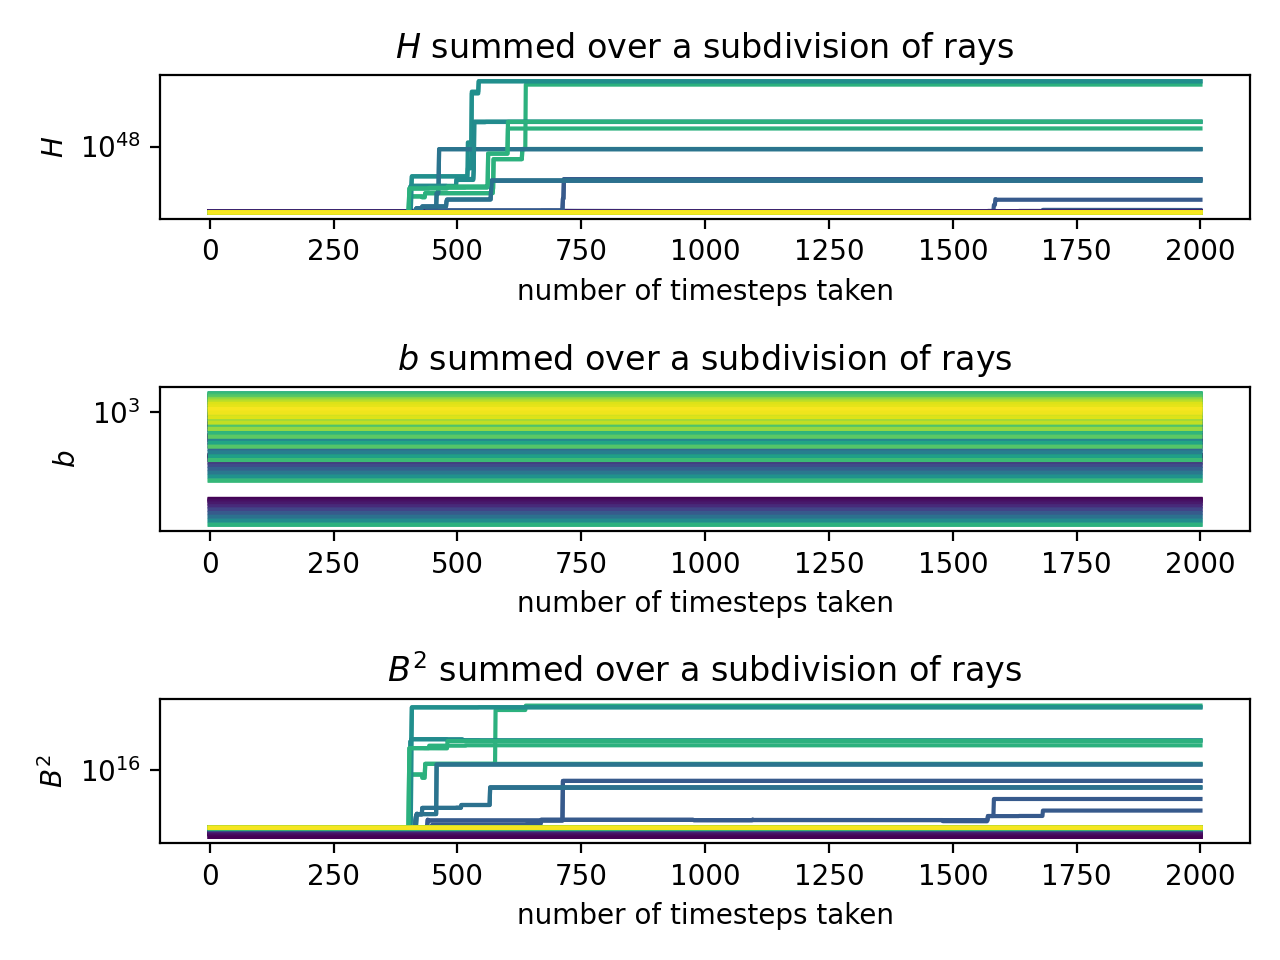

In [14]:
wg.plot_CM(CM1, ['$H$', '$b$', '$B^{2}$'], "Pictures/CM DNeg Sympl"+str(Par)+" "+str(initial_q)+".png", path)

<IPython.core.display.Javascript object>


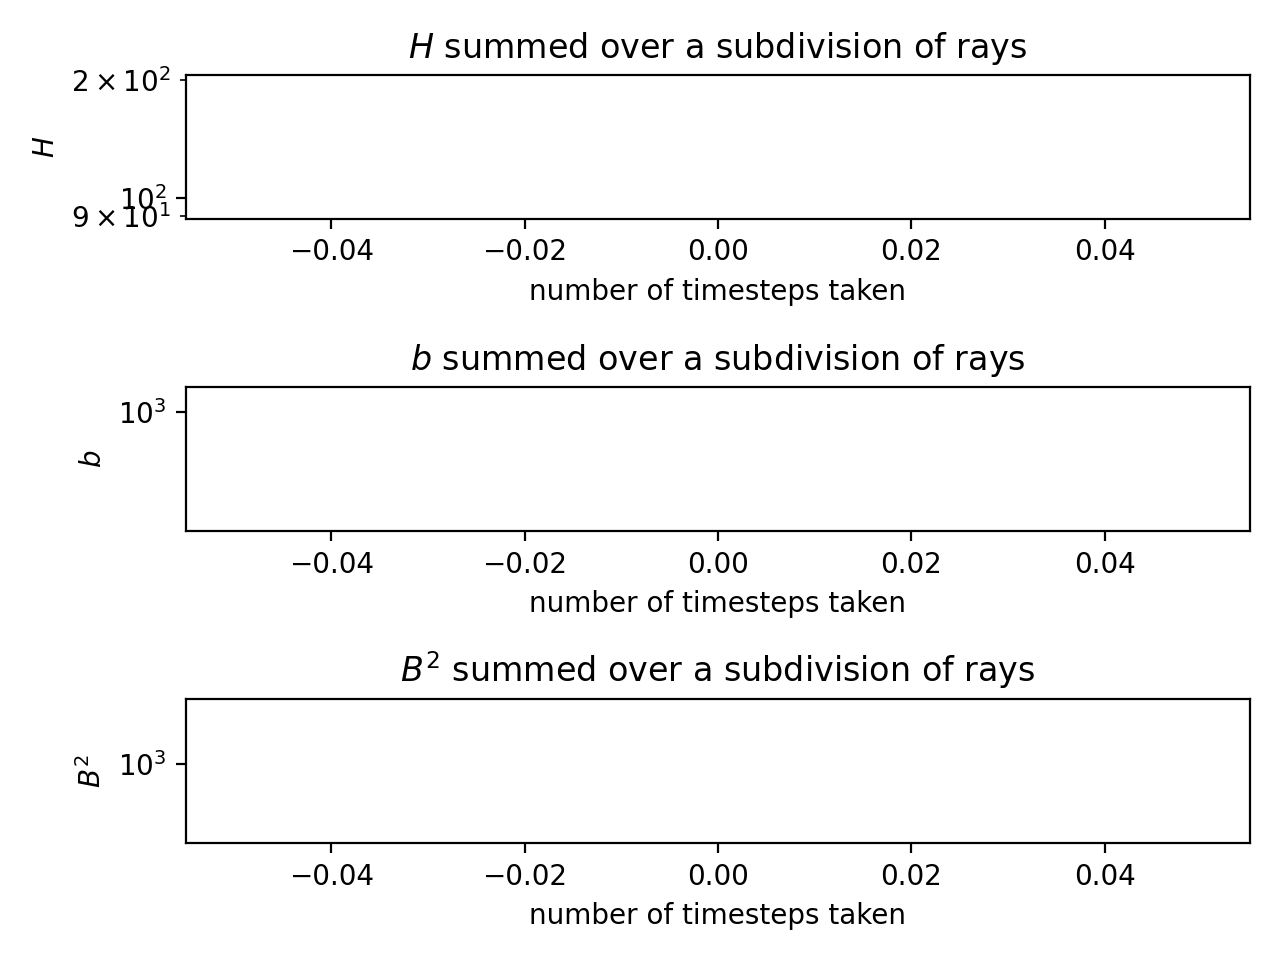

In [15]:
wg.plot_CM(CM2, ['$H$', '$b$', '$B^{2}$'], "Pictures/CM DNeg scipy intgr."+str(Par)+" "+str(initial_q)+".png", path)

In [19]:
Motion2.shape

(1, 2, 3, 400, 400)